<a href="https://colab.research.google.com/github/sankalpachowdhury/Galaxy-Classification-using-CNN/blob/master/Copy_of_Model2_Galaxy_classification_Early_St_%26_MCh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary Python modules 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
%matplotlib inline
import os, random, shutil
from keras_preprocessing import image

#Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Unzipping the zip file to load images.
The 'images_training_rev1.zip' contains 61578 different types of images.

In [ ]:
!unzip "/content/drive/My Drive/Astronomical /Galaxy_classification_project/images_training_rev1.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images_training_rev1/926426.jpg  
  inflating: images_training_rev1/926435.jpg  
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflati

Creating dataframe to load data from csv file for classification.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Astronomical /Galaxy_classification_project/training_solutions_rev1.csv')
print('Galaxy classification dataframe: \n',df.head)
print('\nDataframe shape: ',df.shape)

Galaxy classification dataframe: 
 <bound method NDFrame.head of        GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000        0.0   0.325512
1        100023  0.327001  0.663777  ...   0.000000        0.0   0.000000
2        100053  0.765717  0.177352  ...   0.000000        0.0   0.000000
3        100078  0.693377  0.238564  ...   0.000000        0.0   0.000000
4        100090  0.933839  0.000000  ...   0.000000        0.0   0.000000
...         ...       ...       ...  ...        ...        ...        ...
61573    999948  0.510379  0.489621  ...   0.000000        0.0   0.226257
61574    999950  0.901216  0.098784  ...   0.000000        0.0   0.000000
61575    999958  0.202841  0.777376  ...   0.000000        0.0   0.072296
61576    999964  0.091000  0.909000  ...   0.023065        0.0   0.045334
61577    999967  0.767000  0.140000  ...   0.000000        0.0   0.023380

[61578 rows x 38 columns]>

Dataframe shape:  

**Decision Tree based on questions**

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses

Q2. Is it edge-on? 2 responses

Q3. Is there a bar? 2 responses

Q4. Is there a spiral pattern? 2 responses

Q5. How prominent is the central bulge? 4 responses

Q6. Is there anything "odd" about the galaxy? 2 responses

Q7. How round is the smooth galaxy? 3 responses

Q8. What is the odd feature? 7 responses

Q9. What shape is the bulge in the edge-on galaxy? 3 responses

Q10. How tightly wound are the spiral arms? 3 responses

Q11. How many spiral arms are there? 6 responses

**Paths and the decision tree**

As a result, at each node or question, the total initial probability of a classification will sum to 1.0. Those initial probabilities are then weighted as follows.


**Weighting the responses**

The values of the morphology categories in the solution file are computed as follows. For the first set of responses (smooth, features/disk, star/artifact), the values in each category are simply the likelihood of the galaxy falling in each category. These values sum to 1.0. For each subsequent question, the probabilities are first computed (these will sum to 1.0) and then multiplied by the value which led to that new set of responses. 

Here is a simplified example: a galaxy had 80% of users identify it as smooth, 15% as having features/disk, and 5% as a star/artifact.

```
Class1.1 = 0.80

Class1.2 = 0.15

Class1.3 = 0.05
```
For the 80% of users that identified the galaxy as "smooth", they also recorded responses for the galaxy's relative roundness. These votes were for 50% completely round, 25% in-between, and 25% cigar-shaped. The values in the solution file are thus:
```
Class 7.1 = 0.80 * 0.50 = 0.40

Class 7.2 = 0.80 * 0.25 = 0.20

Class 7.3 = 0.80 * 0.25 = 0.20
```
The reason for this weighting is to emphasize that a good solution must get the high-level, large-scale morphology categories correct. The best solutions, though, will also have high levels of accuracy on the detailed solutions that are further down the decision tree.

# Daraframe segmentation using Decision tree
Based on the survey 38 different result categories stored in the dataframe, images are segregated into 3 main categories

**1. Elliptical,** 
**2. Lenticular,** 
**3. Spiral**

Based on the mentioned conditions 3 lists are created which stores the galaxy ids of the corresponding classes.



In [ ]:
elliptical = df[(df['Class1.1']>0.8) & (df['Class7.1']>0.4)]['GalaxyID'].tolist()
lenticular = df[(df['Class1.1']>0.8) & (df['Class7.2']>0.4)]['GalaxyID'].tolist()
spiral = df[(df['Class1.2']>0.8) & (df['Class2.1']>0.4)]['GalaxyID'].tolist()
galaxy_names = ['elliptical','lenticular','spiral']
galaxy_ids = [elliptical, lenticular, spiral]

for serial, galaxy_class in enumerate(galaxy_ids):
  print('Total number of {0} examples: {1}'.format(galaxy_names[serial],len(galaxy_class)))

Total number of elliptical examples: 4555
Total number of lenticular examples: 3861
Total number of spiral examples: 3078


#Spliting Images based on labels

Based on the **'ids'** corresponding to different types of galaxies(**elliptical, lenticular,spiral**) the images are stored in different folders, for both train and validation dataset
```
Source path: /content/images_training_rev1 
Train_directory: /content/data/train
Validation_directory: /content/data/validation
```

In [ ]:
source_path = '/content/images_training_rev1'
dest_path = '/content/data'

def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')

for serial, galaxy_class in enumerate(galaxy_ids):
  _proc_images(source_path, dest_path, galaxy_names[serial], galaxy_class, 0.9)

elliptical done!
lenticular done!
spiral done!


#Data Augmentation


Install **Augmentor** package

In [ ]:
!pip install Augmentor

In [ ]:
train_dir = '/content/Data1/Train/'
validation_dir = '/content/Data1/Test/'

import Augmentor

# Data augmentation for Training set
for serial, galaxy_class in enumerate(galaxy_ids):
  p = Augmentor.Pipeline(source_directory='/content/data/train/'+galaxy_names[serial],output_directory = train_dir+galaxy_names[serial])
  #Defining methods of Image Augmentation
  p.rotate90(probability=0.5)
  p.rotate270(probability=0.5)
  p.flip_left_right(probability=0.8)
  p.flip_top_bottom(probability=0.3)
  p.resize(probability=1.0, width=150, height=150)

  p.sample(8000)

# Data augmentation for Validation set
for serial, galaxy_class in enumerate(galaxy_ids):
  v = Augmentor.Pipeline(source_directory='/content/data/validation/'+galaxy_names[serial],output_directory = validation_dir+galaxy_names[serial])
  #Defining methods of Image Augmentation
  v.rotate90(probability=0.5)
  v.rotate270(probability=0.5)
  v.flip_left_right(probability=0.8)
  v.flip_top_bottom(probability=0.3)
  v.resize(probability=1.0, width=150, height=150)

  v.sample(1000)

Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 4099 image(s) found.
Output directory set to /content/Data1/Train/elliptical.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD75E37F0>: 100%|██████████| 8000/8000 [00:51<00:00, 154.31 Samples/s]
Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 3474 image(s) found.
Output directory set to /content/Data1/Train/lenticular.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD7907550>: 100%|██████████| 8000/8000 [00:51<00:00, 154.78 Samples/s]
Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 2770 image(s) found.
Output directory set to /content/Data1/Train/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD7E64BA8>: 100%|██████████| 8000/8000 [00:52<00:00, 153.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BDDBE5470>:   0%|          | 4/1000 [00:00<02:51,  5.79 Samples/s]

Initialised with 456 image(s) found.
Output directory set to /content/Data1/Test/elliptical.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD7964128>: 100%|██████████| 1000/1000 [00:06<00:00, 156.11 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD7E646A0>:   2%|▏         | 15/1000 [00:00<00:34, 28.62 Samples/s]

Initialised with 387 image(s) found.
Output directory set to /content/Data1/Test/lenticular.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD8334EF0>: 100%|██████████| 1000/1000 [00:06<00:00, 154.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BD7964630>:   2%|▏         | 17/1000 [00:00<00:27, 36.05 Samples/s]

Initialised with 308 image(s) found.
Output directory set to /content/Data1/Test/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7F5BE160E2B0>: 100%|██████████| 1000/1000 [00:06<00:00, 154.06 Samples/s]


#Validating results of Augmentation
The scenario after Image Augmentation

In [ ]:
# train_dir = '/content/Data1/Train'
# validation_dir = '/content/Data1/Test'

total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total training images after augmentation:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation images after augmentation:', total_validation)

Total training images after augmentation: 24000
Total validation images after augmentation: 3000


In [ ]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('/content/data/validation/elliptical'): 
    im=Image.open(filename)
    image_list.append(im)

IsADirectoryError: ignored

In [ ]:
target = (150, 150)
batch_size = 32

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    #rotation_range=25,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    #horizontal_flip=True,
                    #zoom_range=0.2
                    )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         target_size=target,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         class_mode='categorical')

Found 24000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
r_coeff = 0.001

In [ ]:
from keras import regularizers


model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # fourth convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    
    # 512 neuron fully connected hidden layer
    #tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
#model1.add()
#tf.keras.layers.Dropout(0.5),
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)       

In [ ]:
model2 = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
from tensorflow.keras.optimizers import Adam 

model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
EPOCHS = 50

Implementing EarlyStopping and ModelCheckpoint 

**Note 1:**
While implementing EarlyStopping, ModelCheckpoint use
**from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint**
instead of 
**from keras.callbacks import EarlyStopping, ModelCheckpoint**
as it throws 'EarlyStopping' object has no attribute 'on_train_batch_begin'
as Early Stopping and all these callbacks should be referenced from Tensorflow module

**Note 2:**
1. baseline val_loss is taken as 0.20, after that earlystopping will be executed  to stop the training
2. The best model will be stored inside **best_model.h5** file

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('val_loss') < 0.2800):
      self.model.stop_training = True

# instance for myCallback

call_stop = myCallback()

In [ ]:
from keras.callbacks import TensorBoard

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

# Create a TensorBoard instance with the path to the logs directory
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Early Stopping object
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience = 50, baseline = 0.2791)

# ModelCheckpoint object
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 0)

history = model.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data = validation_generator,
                    callbacks=[call_stop, mc],
                    verbose=1)

Epoch 1/50
750/750 [==============================] - 123s 165ms/step - loss: 0.2102 - acc: 0.9097 - val_loss: 0.3189 - val_acc: 0.8647
Epoch 2/50
750/750 [==============================] - 124s 165ms/step - loss: 0.2096 - acc: 0.9083 - val_loss: 0.5921 - val_acc: 0.7823
Epoch 3/50
750/750 [==============================] - 123s 164ms/step - loss: 0.2064 - acc: 0.9078 - val_loss: 0.3575 - val_acc: 0.8500
Epoch 4/50
750/750 [==============================] - 124s 165ms/step - loss: 0.2077 - acc: 0.9108 - val_loss: 0.3771 - val_acc: 0.8373
Epoch 5/50
750/750 [==============================] - 124s 165ms/step - loss: 0.2049 - acc: 0.9100 - val_loss: 0.5695 - val_acc: 0.7920
Epoch 6/50
750/750 [==============================] - 124s 165ms/step - loss: 0.2068 - acc: 0.9108 - val_loss: 0.2700 - val_acc: 0.8910


Evaluating the model

**Note:** Here also use
from tensorflow.keras.models import load_model
instead of 
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.models import load_model

saved_model = load_model('best_model.h5')
_, train_acc = saved_model.evaluate(train_generator)
_, validation_acc = saved_model.evaluate(validation_generator)
print('Training accuracy: {0}\nValidation accuracy: {1}'.format(train_acc, validation_acc))

94/94 [==============================] - 3s 28ms/step - loss: 0.2700 - acc: 0.8910
Training accuracy: 0.9104583263397217
Validation accuracy: 0.890999972820282


In [ ]:
print(model.predict_classes(validation_generator))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[1 2 1 ... 1 1 2]


Visualizing the performance of the training

Text(0.5, 1.0, 'Training and Validation Accuracy')

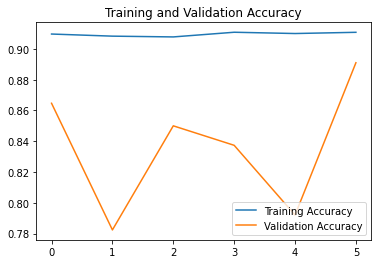

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

#plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



In [ ]:
# launch TensorBoard (data won't show up until after the first epoch)
tensorboard("logs/run_a")

TypeError: ignored

In [ ]:
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_lossesd = PlotLosses()

In [ ]:
model.evaluate(train_generator)

NameError: ignored

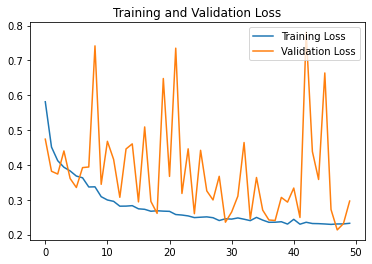

In [ ]:
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()


In [ ]:
target = (150, 150)

In [ ]:

test_generator = train_datagen.flow_from_directory('/content/Test_samples/',
                                                         target_size=target,
                                                         class_mode='categorical')
#model.predict(test_generator)

Found 0 images belonging to 0 classes.


In [ ]:
model.predict('/content/Test_samples/elliptical-1.jpg')

IndexError: ignored

In [ ]:
target = (150, 150)

images = []

from keras.preprocessing import image
path = '/content/Test_samples/'
for img in os.listdir(path):
  img = os.path.join(path, img)
  img = image.load_img(img, target_size = target)
  img = np.expand_dims(img, axis = 0)
  images.append(img)

images = np.vstack(images)
model.predict(images)  
#print(images.shape)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
model.predict_classes(images)

array([2, 2, 0, 2, 2, 2, 1, 2, 2, 2])